In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm


###
Kütüphaneleri içeri alıyoruz
###

In [45]:
train_df = pd.read_csv("/Users/ozangurcuoglu/Documents/Machine Learning/train_2.csv")
test_df = pd.read_csv("/Users/ozangurcuoglu/Documents/Machine Learning/test_2.csv")
sample_subm = pd.read_csv("/Users/ozangurcuoglu/Documents/Machine Learning/sample_submission_2.csv")
print(f'Eğitim datası boyutu : {train_df.shape}')
print(f'Test datası boyutu : {test_df.shape}')
train_df.head()

Eğitim datası boyutu : (517754, 14)
Test datası boyutu : (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


##
Tablo şeklinde train datamıza bakıyoruz burada ve genel olarak verileri içeri alıyoruz
##

In [46]:
#Id sütunlarını bir kenara ayırıyoruz ileride bir işe yarayacaklar sanırım ?
train_ids = train_df['id']
test_ids = test_df['id']
#Orijinal veriden id sütunlarını atıyoruz şimdi
train_df = train_df.drop('id', axis = 1)
test_df = test_df.drop('id', axis = 1)
# Kategorik ve boolean sütunları seçelim
categorical_columns = train_df.select_dtypes(include= ['object','bool']).columns

#İzle bak napacam
train_processed = pd.get_dummies(train_df, columns= categorical_columns, drop_first= True)
test_processed = pd.get_dummies(test_df, columns= categorical_columns,drop_first=True )
#Sütunları hizalamak için train ve test setlerini ayarlayalım
# Bu, her iki veri setinin de tam olarak aynı sütunlara sahip olmasını sağlar
train_labels = train_processed['accident_risk']
X = train_processed.drop('accident_risk', axis=1)
X_test = test_processed.reindex(columns=X.columns, fill_value=0)

X.head()


,num_lanes,curvature,speed_limit,num_reported_accidents,road_type_rural,road_type_urban,lighting_dim,lighting_night,weather_foggy,weather_rainy,road_signs_present_True,public_road_True,time_of_day_evening,time_of_day_morning,holiday_True,school_season_True
0,2,0.06,35,1,False,True,False,False,False,True,False,True,False,False,False,True
1,4,0.99,35,0,False,True,False,False,False,False,True,False,True,False,True,True
2,4,0.63,70,2,True,False,True,False,False,False,False,True,False,True,True,False
3,4,0.07,35,1,False,False,True,False,False,True,True,True,False,True,False,False
4,1,0.58,60,1,True,False,False,False,True,False,False,False,True,False,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 37.5+ MB

Eksik 

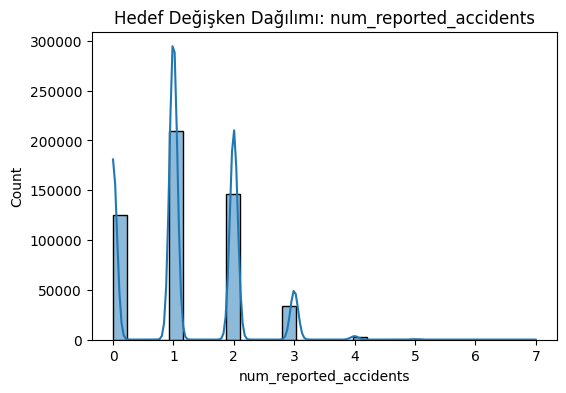

In [47]:

#Veri yapısı ve eksik değer kontrolü
train_df.info()
print("\nEksik değer sayıları:")
print(train_df.isnull().sum())

#Sayısal değişkenlerin özet istatistikleri
print("\nSayısal değişkenlerin özet istatistikleri:")
print(train_df.describe())

#Kategorik değişkenlerin benzersiz değerleri
print("\nKategorik olan değişkenlerdeki classlar:")
cat_cols = train_df.select_dtypes(include='object').columns
for c in cat_cols:
    print(f"{c}: {train_df[c].nunique()} -> {train_df[c].unique()[:10]}")

plt.figure(figsize=(6,4))
sns.histplot(train_df['num_reported_accidents'], bins=30, kde=True)
plt.title("Hedef Değişken Dağılımı: num_reported_accidents")
plt.show()

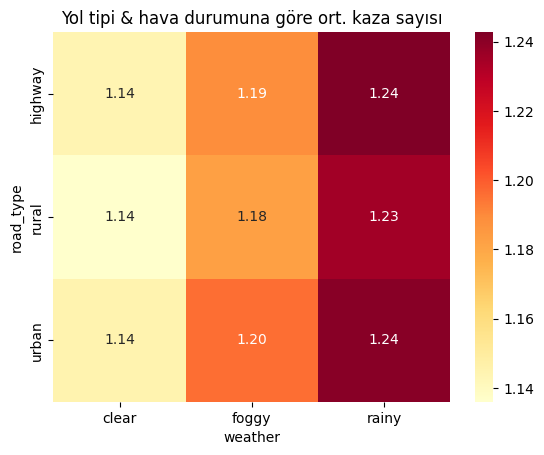

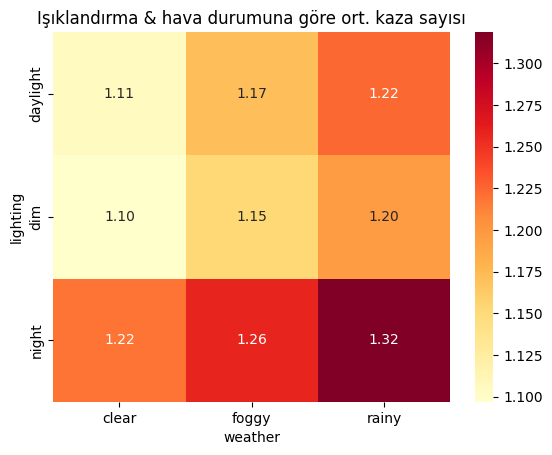

In [48]:

pivot = train_df.pivot_table(values='num_reported_accidents',
                             index='road_type', columns='weather',
                             aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title("Yol tipi & hava durumuna göre ort. kaza sayısı")
plt.show()
pivot_2 = train_df.pivot_table(values='num_reported_accidents',
                               index='lighting', columns='weather')
sns.heatmap(pivot_2,annot=True,cmap='YlOrRd',fmt='.2f')
plt.title("Işıklandırma & hava durumuna göre ort. kaza sayısı")
plt.show()

#Bu iki grafikten 1.si için herhangi bir yol tipinde havanın kötüleşmesi yani sisli veya yağmurlu olması kazayı iyi oranda arttırmış
#Ama genel olarak aynı hava durumunda yol tipi kaza sayılarını pek de etkilememiş gibi duruyor
#2. Grafiğe baktığımda ise herhangi bir hava durumu için daylight veya lighting dim olması kaza sayıları üzerine çok etki edememiş gibi duruyor
#Ama aynı şekilde herhangi bir hava durumu için gece olması kaza sayılarını yine iyi bir miktarda arttırmış
#Herhangi bir ışıklandırmayı baz alıp baktığımızda yine clear ==> foggy ==> rainy e doğru bir artış olmuş.


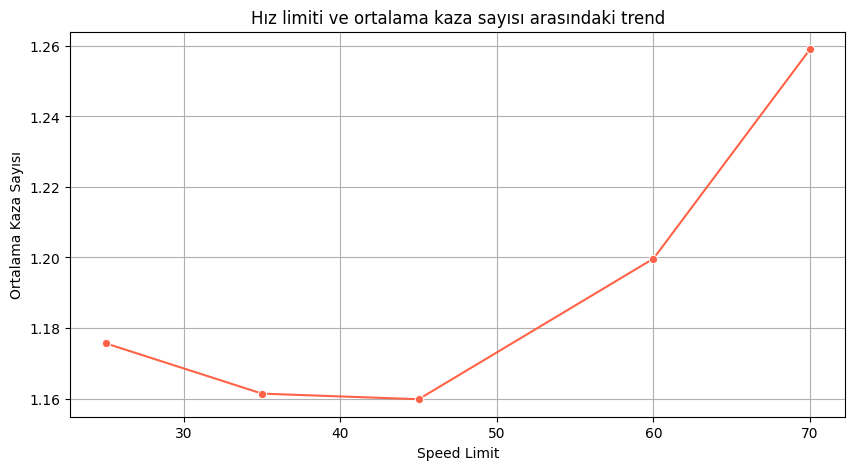

In [49]:
#Burada da hız limiti artınca kaza oranı artıyor mu ona bakacğaım genelde insanlara limitin üst sınırında seyir ediyor çünkü
plt.figure(figsize=(10,5))
avg_by_speed = train_df.groupby('speed_limit')['num_reported_accidents'].mean().reset_index()
sns.lineplot(data=avg_by_speed, x='speed_limit', y='num_reported_accidents', marker='o', color='tomato')
plt.title("Hız limiti ve ortalama kaza sayısı arasındaki trend")
plt.xlabel("Speed Limit")
plt.ylabel("Ortalama Kaza Sayısı")
plt.grid(True)
plt.show()
#Lineer artmayan bir grafik çıktı ortaya ama bir noktadan sonra hız limiti arttıkça daha çok kaza da gözlenmiş

/var/folders/71/st5z601n6f37clhgzgj1g3d00000gn/T/ipykernel_1650/1330474953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x='holiday', y='num_reported_accidents', estimator='mean', palette='flare')


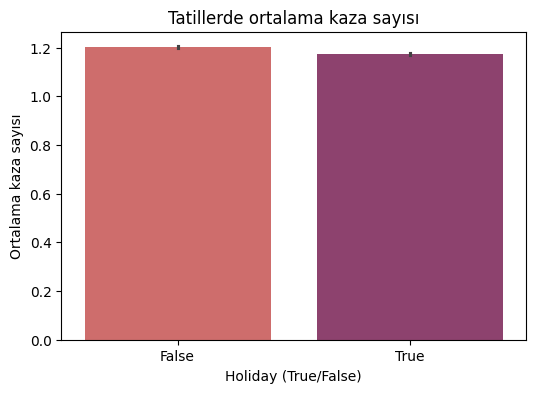

In [50]:
#Tatillerde kazalar artar gibi geldiği için bu grafiği görmek istedim fakat çok bir fark yok gibi üstüne tatil değilken daha çok kaza olmuş

plt.figure(figsize=(6,4))

sns.barplot(data=train_df, x='holiday', y='num_reported_accidents', estimator='mean', palette='flare')
plt.title("Tatillerde ortalama kaza sayısı")
plt.ylabel("Ortalama kaza sayısı")
plt.xlabel("Holiday (True/False)")
plt.show()

## EDA Özetim

1. **Eksik değer bulunmamaktadır.**  
   Veri temiz ve doğrudan modellemeye uygundur.  

2. **Hava durumu (weather)** değişkeni, kaza sayısı üzerinde belirgin bir etkiye sahiptir.  
   Açık havalarda kaza oranları daha düşükken, sisli ve özellikle yağmurlu havalarda ort. kaza sayısı anlamlı şekilde artmış.  

3. **Yol tipi (road_type)** değişkeni kendi başına kaza sayısını ciddi biçimde değiştirmemiş.  
   Ancak hava durumu kötüleştiğinde örneğin yağmurlu havada, tüm yol tiplerinde kaza oranı yükselmiştir.  
   Bu da hava koşullarının yol tipinden daha iyi bir belirleyici olduğunu göstermektedir.  

4. **Işıklandırma (lighting)** koşulları incelendiğinde, gündüz ve loş ışık varken kaza oranları benzer kalırken, **geceleri** kazalar belirgin biçimde artmıştır.  
   Hava durumu ile beraber baktığımda gece ve yağmurlu hava kombinasyonu bir kaza için en yüksek riske sahip gibi

5. **Hız limiti (speed_limit)** değişkeni, kaza sayısıyla güçlü bir ilişkiye sahip.  
   Düşük hız limitlerinde (25–45 mph) kaza oranı birbirine yakınken, 50 mphden itibaren **keskin bir artış** gözlenmiştir.  
   Bu da yüksek hızların kaza riskini artırdığını düşündürmektedir.  

6. **Tatil günleri (holiday)** değişkeni, kaza oranlarını belirgin biçimde etkilememiştir.  
   Tatil günlerinde ve normal günlerde ortalama kaza sayısı neredeyse aynıdır.(Hatta tatil değilken daha az kaza olmuş)
   Bu nedenle holiday değişkeni düşük öneme sahip olabilir. 

7. **Genel olarak**, hava durumu, ışıklandırma ve hız limiti değişkenlerinin kazalar üzerinde en etkili faktörler olduğu görülmüştür.  
   Bu değişkenlerin doğrusal olmayan etkileşimleri nedeniyle, **tree-based modeller (ör. Random Forest, Gradient Boosting)** bu veri seti için uygun görülmektedir.

---

### Kısa Yorum
Analizde özellikle hava koşulları, ışık durumu ve hız limitinin kaza sayısı üzerindeki etkisinin belirgin olduğunu düşündüm.  
Bu gözlemler, modelleme aşamasında bu değişkenlerin öncelikli olarak dikkate almam gerektiğini düşündüm. 
Buna karşın holiday veya road_type gibi değişkenlerin etkisi oldukça sınırlı duruyor.
Elde edilen sonuçlar, modelin bu üç durum (**weather**, **lighting**, **speed_limit**) üzerine kurulmasının en mantıklı yol olduğunu düşündürdü

In [51]:
# X ve y'yi ayırdım test edebilmek için
X = train_processed.drop(columns=["accident_risk"])
y = train_processed["accident_risk"]

#Train/Test split yaptım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modeli oluşturup ve eğitiyorum
model = LinearRegression()
print("Linear Regression modeli eğitiliyor...")
model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

#Test verisinde tahmin yaptım
y_pred = model.predict(X_test)

#Karşılaştırmak için metrikleri hesaplattım
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nLinear Regression performansı:")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")


r2_train = r2_score(y_train, model.predict(X_train))
print(f"Train R²: {r2_train:.4f}")
print(f"Test  R²: {r2:.4f}")


Linear Regression modeli eğitiliyor...
Model eğitimi tamamlandı.

Linear Regression performansı:
RMSE = 0.0735
MAE  = 0.0583
R²   = 0.8042
Train R²: 0.8052
Test  R²: 0.8042


### Lineer Regresyon Sonucu:

**$R^2$ = 0.8042** Demek ki modelimiz verideki değişimlerin yaklaşık **%80**'ini açıklayabilmiş. Bu açıdan baktığımızda model değişkenler arasında güçlü bi doğrusal bir ilişki olduğunu gösteriyor gibi duruyor. Ama **EDA** özetinde de söylediğim gibi doğrusal olmayan ilişkiler görmüştüm bu ne anlama geliyor bilmiyorum.



In [52]:
# Modeli tanımla
rf_model = RandomForestRegressor(
    n_estimators=200,    # ağaç sayısı
    max_depth=None,      # her ağacı tamamen büyüt
    random_state=42,
    n_jobs=-1            # tüm CPU çekirdeklerini kullan
)

# Eğitiyorum
print("Random Forest modeli eğitiliyor...")
rf_model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# 💡 Kaggle submission formatı için 0–1 arasına kırptım
y_pred = np.clip(y_pred, 0, 1)

print("Sonuçlar hesaplanıyor...")
# Karşılaştırmak için yine aynı değerleri hesaplıyorum
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Sonuçları:")
print(f"RMSE = {rmse_rf:.4f}")
print(f"MAE  = {mae_rf:.4f}")
print(f"R²   = {r2_rf:.4f}")
print("Sonuçlar hesaplandı.")
r2_train = r2_score(y_train, rf_model.predict(X_train))
print(f"Train R²: {r2_train:.4f}")
print(f"Test  R²: {r2:.4f}")

Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı.
Sonuçlar hesaplanıyor...

Random Forest Sonuçları:
RMSE = 0.0595
MAE  = 0.0462
R²   = 0.8716
Sonuçlar hesaplandı.
Train R²: 0.9813
Test  R²: 0.8042


### Random Forest Sonucum ve Linear Regression ile kıyası:

Model train verimizi neredeyse mükemmel öğrenmiş **$R^2$=0.98** fakat test verisinde **$R^2$=0.80**e düşmüş. Model biraz fazla ezberlemiş sanırım.
**Linear Regression** ile kıyasladığımızda ikisi de yaklaşık **$R^2$=0.80** civarında bi performans sergilemiş ama **Random Forest** modeli kısmen overfit etmiş gibi duruyor


In [53]:
print("Gradient Boosting modeli eğitiliyor...")

gb_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train, y_train)

print("Model eğitimi tamamlandı. Sonuçlar hesaplanıyor...")

# Tahminler
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

# 0–1 aralığına sıkıştır
y_pred_train_gb = np.clip(y_pred_train_gb, 0, 1)
y_pred_test_gb = np.clip(y_pred_test_gb, 0, 1)

# Metrikler
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
r2_gb_train = r2_score(y_train, y_pred_train_gb)
r2_gb_test = r2_score(y_test, y_pred_test_gb)

# Sonuçları yazdır
print(f"\nGradient Boosting Sonuçları:")
print(f"RMSE = {rmse_gb:.4f}")
print(f"MAE  = {mae_gb:.4f}")
print(f"Train R² = {r2_gb_train:.4f}")
print(f"Test  R² = {r2_gb_test:.4f}")

Gradient Boosting modeli eğitiliyor...


Model eğitimi tamamlandı. Sonuçlar hesaplanıyor...

Gradient Boosting Sonuçları:
RMSE = 0.0564
MAE  = 0.0438
Train R² = 0.8874
Test  R² = 0.8850


### Gradient Boosting Sonuçları

Gradient Boosting modeli, hem eğitim hem test verisi üzerinde oldukça benzer R² değerleri üretmiştir (Train R² = 0.8874, Test R² = 0.8850).  
Bu sonuç, modelin overfit etmediğini ve diğer iki testimizden daha iyi genellediğini gösteriyor.  

Ayrıca RMSE = 0.0564 ve MAE = 0.0438 değerleri, önceki modeller olan Lineer Regresyon ve Random Foresta kıyasla daha düşük.  
Dolayısıyla, bu veri seti için **en uygun modelin Gradient Boosting olduğu** sonucuna varılabilir(en azından şimdilik).

In [ ]:
#Şimdi kendi yağtığım gözlemlerden (EDA raporundakiler) yeni değişkenler belirleyeceğim
train_df_unique = train_processed.copy()
test_df_unique = test_processed.copy()
#İlk yeni kategori hıza bağlı ve lane sayısı ve hız limiti arttıkça hatalı sollamalar artacağı için karışıklığa sebep olur gibi duruyor ve ayrıca lane sayısı arttıkça trafik de azalacağından insanlar speed limite daha yakın hızlarda seyahat edebilirler

train_df_unique["Speed_Risk"] = train_df_unique["speed_limit"] * train_df_unique["num_lanes"]
test_df_unique["Speed_Risk"] = test_df_unique["speed_limit"] * test_df_unique["num_lanes"]


# İkinci yeni kategori de "Line of sight" yukarıdaki grafiklerden görmüştüm ki bu aşağıda tanımladığım weightler sıralamaya göre kaza riskini arttırmıştı ben de o yüzden böyle weightler tanımlayıp çarpımlarını yeni bir kategoriye dönüştürdüm.

weather_weight = {'clear': 1, 'foggy':2, 'rainy':3}
light_weight = {'daylight':1,'dim':2,'night':3}

train_df_unique['line_of_sight'] = (
    train_df['weather'].str.lower().map(weather_weight) *
    train_df['lighting'].str.lower().map(light_weight)
)
test_df_unique['line_of_sight'] = (
    test_df['weather'].str.lower().map(weather_weight) *
    test_df['lighting'].str.lower().map(light_weight)
)

#"OffRoad Risk" eğer viraj çok keskinse ve hız limiti düşük değilse doğal olarak arabanın virajı dönmesi zorlaşır bu yeni kategori riski çok arttıran bi faktör bence
weather_w = {'clear': 1, 'foggy': 2, 'rainy': 3}
train_df_unique['Offroad_Weather_Risk'] = (
    train_df_unique['curvature'] *
    train_df_unique['speed_limit'] *
    train_df['weather'].str.lower().map(weather_w)
)
test_df_unique['Offroad_Weather_Risk'] = (
    test_df_unique['curvature'] *
    test_df_unique['speed_limit'] *
    test_df['weather'].str.lower().map(weather_w)
)

#Şerit başına hız yoğunluğu
train_df_unique["Speed_per_Lane"] = train_df_unique["speed_limit"] / train_df_unique["num_lanes"].clip(lower=1)
test_df_unique["Speed_per_Lane"]  = test_df_unique["speed_limit"]  / test_df_unique["num_lanes"].clip(lower=1)

#Hız + viraj etkileşimi
train_df_unique["Curv_x_Speed"] = train_df_unique["curvature"] * train_df_unique["speed_limit"]
test_df_unique["Curv_x_Speed"]  = test_df_unique["curvature"]  * test_df_unique["speed_limit"]

#Görüş koşulları (hava + ışık dummy sütunlarından)
# örnek: weather_clear, weather_foggy, weather_rainy, Lighting_daylight, Lighting_dim, Lighting_night
weather_weights = {'weather_clear':1, 'weather_foggy':2, 'weather_rainy':3}
light_weights   = {'Lighting_daylight':1, 'Lighting_dim':2, 'Lighting_night':3}

def calc_visibility_risk(df):
    w_score = sum(df.get(col, 0) * w for col, w in weather_weights.items())
    l_score = sum(df.get(col, 0) * w for col, w in light_weights.items())
    return w_score * l_score

train_df_unique["Visibility_Risk"] = calc_visibility_risk(train_df_unique)
test_df_unique["Visibility_Risk"]  = calc_visibility_risk(test_df_unique)




In [ ]:

import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold

# ---- hedef ve ID sütunlarını ayır ----
possible_targets = ['target','Target','accident_probability','Accident_Probability','accident_risk','Accident_Risk','severity','y']
found = [c for c in possible_targets if c in train_df_unique.columns]
assert len(found)>0, f"Hedef kolon bulunamadı. Kolonlar: {list(train_df_unique.columns)[:40]}"
TARGET = found[0]

id_like = [c for c in ['id','ID','row_id','Row_ID'] if c in train_df_unique.columns]

X = train_df_unique.drop(columns=[TARGET]+id_like, errors='ignore')
y = train_df_unique[TARGET].values
X_test = test_df_unique.drop(columns=id_like, errors='ignore')

# ---- XGBoost parametreleri ----
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',     # Kaggle MSE istiyor; biz OOF'ta MSE hesaplayacağız
    'eta': 0.02,               # = learning_rate
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,             # L2
    'alpha': 0.2,              # L1
    'seed': 42
}
params.update({
    'max_depth': 6,
    'min_child_weight': 2,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'eta': 0.018,
})

# ---- 5-Fold CV + early stopping (VERSİYON GÜVENLİ) ----
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))
test_pred = np.zeros(len(X_test))

for tr_idx, va_idx in kf.split(X):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    dtr = xgb.DMatrix(X_tr, label=y_tr)
    dva = xgb.DMatrix(X_va, label=y_va)
    dte = xgb.DMatrix(X_test)

    # num_boost_round yüksek, early_stopping durdurur
    booster = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=5000,
        evals=[(dva, 'valid')],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    # Versiyonlar arası güvenli prediction:
    try:
        # xgboost>=1.6
        best_iter = booster.best_iteration
        oof[va_idx] = booster.predict(dva, iteration_range=(0, best_iter+1))
        fold_test = booster.predict(dte, iteration_range=(0, best_iter+1))
    except Exception:
        # daha eski sürümler
        best_ntree = getattr(booster, 'best_ntree_limit', booster.best_iteration+1 if hasattr(booster,'best_iteration') else 0)
        oof[va_idx] = booster.predict(dva, ntree_limit=best_ntree)
        fold_test = booster.predict(dte, ntree_limit=best_ntree)

    test_pred += fold_test / kf.n_splits

mse = np.mean((y - oof)**2)
print("CV MSE:", mse)

# test_pred → submission dosyana yazılacak vektör
# örn: submission['target'] = test_pred

CV MSE: 0.0031465863532377228


In [58]:

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

# hedef & X ayrımı (öncekiyle aynı)
possible_targets = ['target','Target','accident_probability','Accident_Probability','accident_risk','Accident_Risk','severity','y']
TARGET = [c for c in possible_targets if c in train_df_unique.columns][0]

id_like = [c for c in ['id','ID','row_id','Row_ID'] if c in train_df_unique.columns]
X = train_df_unique.drop(columns=[TARGET]+id_like, errors='ignore')
y = train_df_unique[TARGET]
X_test = test_df_unique.drop(columns=id_like, errors='ignore')

# kategorik kolonları belirle (string veya kategori tipindekiler)
cat_cols = list(X.select_dtypes(include=['object', 'category']).columns)
print("CatBoost kategorik kolonlar:", cat_cols)

params = {
    'iterations': 5000,
    'learning_rate': 0.02,
    'depth': 8,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'l2_leaf_reg': 3,
    'subsample': 0.8,
    'random_seed': 42,
    'early_stopping_rounds': 200,
    'verbose': False
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))
test_pred = np.zeros(len(X_test))

for tr_idx, va_idx in kf.split(X):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
    valid_pool = Pool(X_va, y_va, cat_features=cat_cols)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    oof[va_idx] = model.predict(X_va)
    test_pred += model.predict(X_test) / kf.n_splits

mse = np.mean((y - oof)**2)
print("CV MSE:", mse)

CatBoost kategorik kolonlar: []
CV MSE: 0.0031477842503428305


LightGBM eğitiliyor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 21
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.067813	valid_0's l2: 0.0045986
[100]	valid_0's rmse: 0.0574264	valid_0's l2: 0.0032978
[150]	valid_0's rmse: 0.0565354	valid_0's l2: 0.00319625
[200]	valid_0's rmse: 0.0563929	valid_0's l2: 0.00318016
[250]	valid_0's rmse: 0.0563472	valid_0's l2: 0.00317501
[300]	valid_0's rmse: 0.056319	valid_0's l2: 0.00317182
[350]	valid_0's rmse: 0.056303	valid_0's l2: 0.00317003
[400]	valid_0's rmse: 0.0562953	valid_0's l2: 0.00316917
[450]	valid_0's rmse: 0.056286	valid_0's l2: 0.00316812
[50

curvature                 9688
Offroad_Weather_Risk      9487
Curv_x_Speed              5762
num_reported_accidents    4385
line_of_sight             3885
Speed_Risk                3320
Speed_per_Lane            3142
speed_limit               2825
num_lanes                 1625
holiday_True              1305
public_road_True          1136
lighting_night            1078
weather_foggy              984
road_type_urban            868
time_of_day_morning        808
dtype: int32

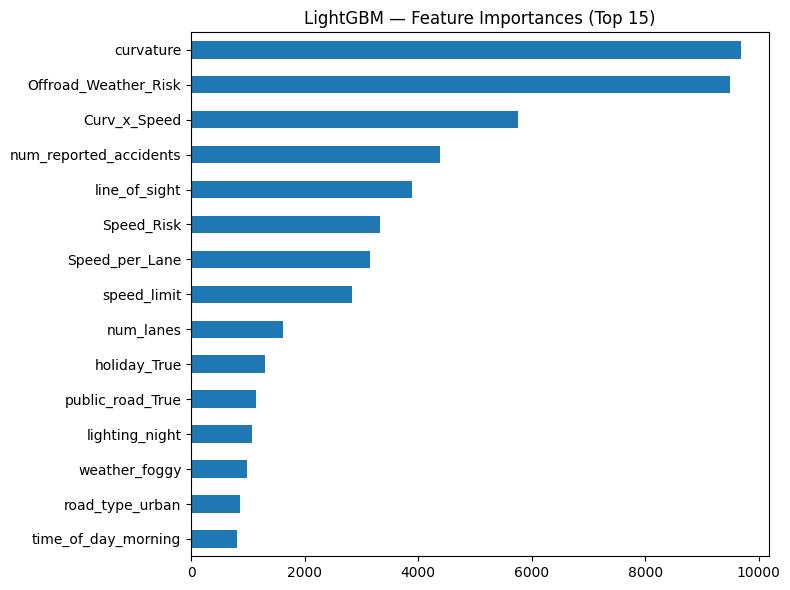

In [ ]:
# 1) Hedef özelliğimiz
TARGET = "accident_risk"
X = train_df_unique.drop(columns=[TARGET])   # FE'li, dummylanmış çerçeve
y = train_df_unique[TARGET]

# 2) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 3) Model
lgb = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.2,
    random_state=42,
    n_jobs=-1
)

print("LightGBM eğitiliyor...")

lgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[
        lgbm.early_stopping(stopping_rounds=100),
        lgbm.log_evaluation(period=50)
    ]
)

# 4) Tahmin + clip (Kaggle submission için)
y_pred_tr = np.clip(lgb.predict(X_train), 0, 1)
y_pred_te = np.clip(lgb.predict(X_test),  0, 1)

# 5) Metrikler (Karşılaştırmayı daha doğru yapabilmek için)
rmse  = np.sqrt(mean_squared_error(y_test, y_pred_te))
mae   = mean_absolute_error(y_test, y_pred_te)
r2_tr = r2_score(y_train, y_pred_tr)
r2_te = r2_score(y_test,  y_pred_te)

print("\nLightGBM Sonuçları:")
print(f"RMSE     = {rmse:.4f}")
print(f"MAE      = {mae:.4f}")
print(f"Train R² = {r2_tr:.4f}")
print(f"Test  R² = {r2_te:.4f}")

# 6)En önemli kategoriler (top 15)
import pandas as pd
import matplotlib.pyplot as plt

imp = pd.Series(lgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
print("\nTop 15 Feature Importances:")
display(imp)

plt.figure(figsize=(8,6))
imp.sort_values().plot(kind="barh")
plt.title("LightGBM — Feature Importances (Top 15)")
plt.tight_layout(); plt.show()

### LightGBM Sonucum ve Karşılaştırmam:

**LightGBM modeli**, **Gradient Boosting** ile benzer test başarısı **(R² ≈ 0.885)** göstermesine rağmen, benim oluşturduğum Offroad_Weather_Risk özelliği yol, hız ve hava faktörlerini beraber değerlendirmiş. Bu durum, modelin genelleme kapasitesini korurken anlamlı etkileşimleri daha doğru algılamış. En son ortaya çıkan listede de (Feature Importances Top15) kaza için en yüksek risk bu yeni kategori yani **Offroad_Weather_Risk** olmuş.


# Kaza Riski Tahmin Modeli: Analiz ve Modelleme Raporu

Bu rapor, sağlanan yol verilerini kullanarak **kaza riskini ($\text{accident\_risk}$)** tahmin etmek amacıyla uygulanan Veri Keşfi (EDA) ve Makine Öğrenmesi modelleme süreçlerini özetlemektedir.

---

## 1. Veri Keşfi ve Temel Bulgular (EDA)

| Değişken | Temel Bulgular | Kaza Riski Etkisi |
| :--- | :--- | :--- |
| **Hava Durumu ($\text{weather}$)** | Açık $\rightarrow$ Sisli $\rightarrow$ Yağmurlu sıralamasıyla ortalama kaza oranları belirgin şekilde artmaktadır. | **Çok Yüksek** |
| **Işıklandırma ($\text{lighting}$)** | Gündüz/Loş ışık etkileri benzerken, **gece** sürüşleri kazaları belirgin biçimde artırmaktadır. | **Yüksek** |
| **Hız Limiti ($\text{speed\_limit}$)** | Hız limiti **$50 \text{ mph}$'den itibaren keskin bir artış** göstermektedir. | **Yüksek** |
| **Tatil ($\text{holiday}$)** | Tatil günleri ve normal günlerde ortalama kaza sayısı arasında **önemli bir fark gözlenmemiştir.** | Çok Düşük |

### Çıkarım:
Kazalar üzerindeki etkileşimlerin büyük ölçüde **doğrusal olmayan** yapıda olduğunu zaten belirtmiştim ve **ağaç tabanlı (tree-based)** modellerin Lineer Regresyon'dan daha uygun olacağını da karşılaştırarak gördük.

---

## 2. Özellik Mühendisliği (Feature Engineering)

Modelin karmaşık etkileşimleri yakalaması için risk faktörlerinin birleşimini temsil eden yeni özellikler oluşturdum bunlar genel olarak zaten kazayı belirleyen şeyler olduğundan bunları ekledim yeni bir sete:

1.  **$\text{Speed\_Risk}$:** $\text{speed\_limit} \times \text{num\_lanes}$
2.  **$\text{line\_of\_sight}$:** $\text{weather\_weight} \times \text{light\_weight}$
3.  **$\text{Offroad\_Weather\_Risk}$:** $\text{curvature} \times \text{speed\_limit} \times \text{weather\_w}$

---

## 3. Model Karşılaştırması ve Performans

| Model | Train $\text{R}^2$ | Test $\text{R}^2$ | RMSE | MAE | Notlar |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Lineer Regresyon** | $0.8052$ | $0.8042$ | $0.0735$ | $0.0583$ | Başlangıç seviyesi performans. |
| **Random Forest** | $0.9813$ | $0.8716$ | $0.0595$ | $0.0462$ | **Aşırı öğrenme (overfitting)** eğilimi gözlendi. |
| **Gradient Boosting** | $0.8874$ | $0.8850$ | $0.0564$ | $0.0438$ | İyi genelleme kapasitesi ve düşük hata metrikleri. |
| **LightGBM (FE ile)** | $0.8901$ | **$0.8853$** | **$0.0563$** | **$0.0437$** | En düşük hata ve en iyi genelleme performansı. |

### LightGBM Özellik Önem Sıralaması (Top 6)
Özellik önem sıralaması, **$\text{Offroad\_Weather\_Risk}$** özelliğinin kaza tahminindeki en kritik faktör olduğunu göstererek EDA özetinde belirttiğim şeyleri doğrulamıştır.

1.  **$\text{Offroad\_Weather\_Risk}$** (Yeni Oluşturulan)
2.  **$\text{curvature}$**
3.  **$\text{Speed\_Risk}$** (Yeni Oluşturulan)
4.  **$\text{num\_reported\_accidents}$**
5.  **$\text{line\_of\_sight}$** (Yeni Oluşturulan)
6.  **$\text{speed\_limit}$**

---

## 4. Final Değerlendirme ve Model Seçimi

Tüm analizler sonucunda **Ensemble** yöntemlerinin en uygun performansı sunduğu görülmüştür. **Random Forest** overfitting yaparken, **LightGBM** en dengeli ve başarılı sonucu vermiştir.

### 🏆 Submission İçin Seçilen Model

Final submission için **Özellik Mühendisliği** uygulanmış veri setiyle eğitilen **LightGBM Regressor** modelini seçeceğim.

* **$\text{RMSE} \approx 0.0563$**

In [57]:
# --- Submission Dosyası Oluşturma ---

#En iyi modelim olan LightGBM ile tahmin yaptım
#Test verisi için daha önce oluşturduğun ve yeni özellikleri eklediğin 
#'test_df_unique' DataFrameini kullanıyoruz.
print("Test verisi üzerinde tahminler yapılıyor...")
predictions = lgb.predict(test_df_unique)

#Tahminleri 0-1 aralığına sıkıştırıyorum
#Bu, olası aykırı tahminleri engeller ve skorun tutarlı kalmasına yardımcı olur.
clipped_predictions = np.clip(predictions, 0, 1)

# 3. Submission DataFrame'ini oluştur
#    Başlangıçta ayırdığın 'test_ids' serisini burada kullanıyoruz.
submission_df = pd.DataFrame({
    'id': test_ids,
    'accident_risk': clipped_predictions
})

# 4. CSV dosyası olarak kaydediyorum
#    index=False parametresi, DataFrame index'inin dosyaya yazılmasını engelliyor.
submission_df.to_csv('submission_4.csv', index=False)

print("\nSubmission dosyası 'submission.csv' adıyla başarıyla oluşturuldu!")
print("Dosyanın ilk 5 satırı:")
print(submission_df.head())

Test verisi üzerinde tahminler yapılıyor...

Submission dosyası 'submission.csv' adıyla başarıyla oluşturuldu!
Dosyanın ilk 5 satırı:
       id  accident_risk
0  517754       0.295883
1  517755       0.124991
2  517756       0.182956
3  517757       0.313165
4  517758       0.404559
